In [1]:
import os
import copy
import keras
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import ImageFile
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras.layers import GlobalMaxPooling2D,Input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split

In [2]:
# random seed
np.random.seed(2021)
tf.random.set_seed(2021)

In [3]:
# fix error with truncated image files
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
train_df = pd.read_csv('/home/jupyter-chima/data/correa/train_censored.csv')
validate_df = pd.read_csv('/home/jupyter-chima/data/correa/val_censored.csv')

In [5]:
train_df = train_df[train_df.Race.isin(['ASIAN','BLACK/AFRICAN AMERICAN','WHITE'])]
validate_df = validate_df[validate_df.Race.isin(['ASIAN','BLACK/AFRICAN AMERICAN','WHITE'])]

In [6]:
train_df.hiti_path = train_df.hiti_path.astype(str)
validate_df.hiti_path = validate_df.hiti_path.astype(str)

In [7]:
#remove 0 byte images
train_df = train_df[~train_df.hiti_path.str.contains('406e0996e5f1cf082487d7d096574d10b46c0c52710222a4884db1cc|dd97e997cc2a4166dc6e192cb62e29553aa28f4671d98c9577e32cfd|6224290209c45bb2b3e07b3b3a27778d1d10f7953567b3c59158e099')]
validate_df = validate_df[~validate_df.hiti_path.str.contains('406e0996e5f1cf082487d7d096574d10b46c0c52710222a4884db1cc|dd97e997cc2a4166dc6e192cb62e29553aa28f4671d98c9577e32cfd|6224290209c45bb2b3e07b3b3a27778d1d10f7953567b3c59158e099')]

In [8]:
train_df.Race.value_counts()

WHITE                     91369
BLACK/AFRICAN AMERICAN    87139
ASIAN                      6457
Name: Race, dtype: int64

In [9]:
validate_df.Race.value_counts()

BLACK/AFRICAN AMERICAN    7540
WHITE                     6656
ASIAN                      530
Name: Race, dtype: int64

In [10]:
IMAGE_WIDTH, IMAGE_HEIGHT = (224, 224)
EPOCHS = 20
BATCH_SIZE = 256
learning_rate = 1e-3
decay_val= 0.0 
image_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)

In [11]:
# setup train, valid, and test image data generators
train_gen = ImageDataGenerator(
            rotation_range=15, 
            fill_mode='constant',
            zoom_range=0.1,
            horizontal_flip=True
)

validate_gen = ImageDataGenerator()

In [12]:
train_batches = train_gen.flow_from_dataframe(
    train_df, 
    x_col="hiti_path", 
    y_col="Race", 
    class_mode="categorical",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    shuffle=True,
    seed=2021,
    batch_size=BATCH_SIZE, 
    dtype='float32'
)

validate_batches = validate_gen.flow_from_dataframe(
    validate_df,
    x_col="hiti_path", 
    y_col="Race", 
    class_mode="categorical",
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    shuffle=False,
    batch_size=BATCH_SIZE, 
    dtype='float32'
)        

Found 184965 validated image filenames belonging to 3 classes.
Found 14726 validated image filenames belonging to 3 classes.


In [13]:
# see the class names
class_names = train_df.Race.value_counts().index.tolist()
class_names.sort()
class_names

['ASIAN', 'BLACK/AFRICAN AMERICAN', 'WHITE']

In [14]:
# create model
n_labels = len(class_names)

base_model = EfficientNetB0( 
    input_shape=image_shape,
    include_top=False,
    weights='imagenet',
    drop_connect_rate=0.4
)

inputs = Input(image_shape)
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(n_labels, name='dense_logits')(x)
output = tf.keras.layers.Activation('softmax', dtype='float32', name='predictions')(x)
model = Model(inputs= inputs, outputs=output)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_logits (Dense)         (None, 3)                 3843      
_________________________________________________________________
predictions (Activation)     (None, 3)                 0         
Total params: 4,053,414
Trainable params: 4,011,391
Non-trainable params: 42,023
_________________________________________________________________


In [15]:
adam_opt = optimizers.Adam(lr=learning_rate, decay=decay_val)

model.compile(
    optimizer=adam_opt,
    loss=tf.losses.CategoricalCrossentropy(),
    metrics=[
        tf.keras.metrics.AUC(curve='ROC', name='ROC-AUC'),
        tf.keras.metrics.AUC(curve='PR', name='PR-AUC')
    ],
)

In [ ]:
save = ModelCheckpoint(
    '/home/jupyter-chima/Bias/Emory_CXR/Three_classes/EfficientNet/Checkpoint/', 
    monitor="val_PR-AUC", 
    save_best_only=True,
    save_weights_only=True, 
    mode='max',
    verbose=1
)
# stop = EarlyStopping(monitor='val_loss', mode='min', patience=6, restore_best_weights=True)
scheduler = ReduceLROnPlateau(
    monitor="val_loss", 
    mode='min', 
    factor=0.1, 
    patience=3, 
    min_lr=1e-6, 
    verbose=1
)
logger = CSVLogger('/home/jupyter-chima/Bias/Emory_CXR/Three_classes/EfficientNet/training.log')
history = model.fit(
    train_batches, 
    epochs=EPOCHS, 
    validation_data=validate_batches, 
    verbose=1, 
    callbacks=[save, scheduler, logger]
)

Epoch 1/20
723/723 [==============================] - ETA: 0s - loss: 0.3796 - ROC-AUC: 0.9605 - PR-AUC: 0.9298 
Epoch 00001: val_PR-AUC improved from -inf to 0.80751, saving model to /home/jupyter-chima/Bias/Emory_CXR/Three_classes/EfficientNet/Checkpoint/
723/723 [==============================] - 18244s 25s/step - loss: 0.3796 - ROC-AUC: 0.9605 - PR-AUC: 0.9298 - val_loss: 0.8233 - val_ROC-AUC: 0.8814 - val_PR-AUC: 0.8075
Epoch 2/20
723/723 [==============================] - ETA: 0s - loss: 0.2799 - ROC-AUC: 0.9778 - PR-AUC: 0.9599 
Epoch 00002: val_PR-AUC improved from 0.80751 to 0.97295, saving model to /home/jupyter-chima/Bias/Emory_CXR/Three_classes/EfficientNet/Checkpoint/
723/723 [==============================] - 19234s 27s/step - loss: 0.2799 - ROC-AUC: 0.9778 - PR-AUC: 0.9599 - val_loss: 0.2301 - val_ROC-AUC: 0.9847 - val_PR-AUC: 0.9729
Epoch 3/20
723/723 [==============================] - ETA: 0s - loss: 0.2480 - ROC-AUC: 0.9823 - PR-AUC: 0.9677 
Epoch 00003: val_PR-AUC di

In [18]:
model.save('/home/jupyter-chima/Bias/Emory_CXR/Three_classes/EfficientNet/Emory_CXR_three_classes_EfficientNet.h5')

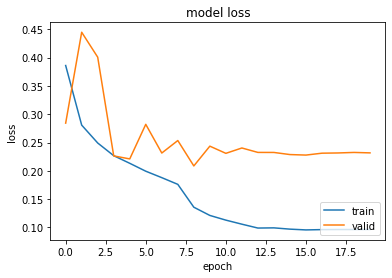

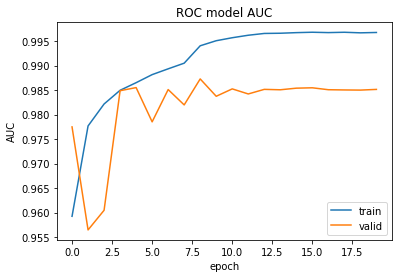

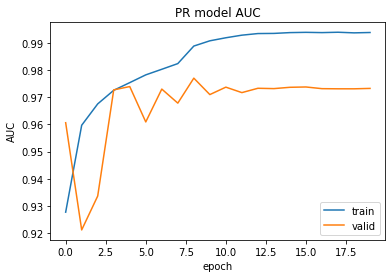

In [19]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
    
# summarize history for ROC auc
plt.plot(history.history['ROC-AUC'])
plt.plot(history.history['val_ROC-AUC'])
plt.title('ROC model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

# summarize history for ROC auc
plt.plot(history.history['PR-AUC'])
plt.plot(history.history['val_PR-AUC'])
plt.title('PR model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()